In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  15 08:50:58 2021
@author: zeqinhuang
"""

import xarray as xr
import numpy as np
import pandas as pd
import os
import proplot as pplot
import cmaps
from matplotlib import pyplot as plt
from scipy.stats import norm
import glob
import matplotlib as mpl
import xesmf as xe
from cartopy.util import add_cyclic_point
from scipy.stats import linregress
from scipy.stats import theilslopes
import geopandas as gp
import seaborn as sns
import random
from warnings import simplefilter

import matplotlib.patches as pch
import cartopy
import cartopy.crs as ccrs
mapcrs = ccrs.PlateCarree(central_longitude=0, globe=None)
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from utils import *
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

simplefilter(action='ignore', category=FutureWarning)

In [2]:
def cal_5year_moving_avg(time_series):
    time_series = time_series.rolling(5,center=True,min_periods=1,axis=0).mean()
    return time_series

def Regridder(data):
    data = data.interp(lat=target_griddes['lat'],lon=target_griddes['lon'], method="nearest")
    return data

def regrid(data,mask='Global'):
    
    data_regridded = Regridder(data)
    if mask == 'Global':
        data_regridded = data_regridded * mask_global
    elif mask != 'Global':
        data_regridded = sel_lonlat_range(
            mask_global,lon_min=domain_lonlat[mask]['lon_min'],
            lon_max=domain_lonlat[mask]['lon_max'],
            lat_min=domain_lonlat[mask]['lat_min'],
            lat_max=domain_lonlat[mask]['lat_max'])
    else:
        pass
    return data_regridded

def cal_5year_moving_avg(time_series):
    time_series = time_series.rolling(5,center=True,min_periods=1,axis=0).mean()
    return time_series

def get_mme_series(name,forcing):
    forcing_shortname = {'historical':'hist','hist-GHG':'GHG','hist-aer':'aer','hist-nat':'nat'}
    path = forcing_dir[forcing] + name + '_' + forcing_shortname[forcing] + '_mme.nc'
    mme  = xr.open_dataset(path)
    mme_mask = regrid(data=mme, mask = 'Global')
    area_weights = np.cos(np.deg2rad((mme_mask.lat)))
    area_weights.name = 'weights'
    mme_regrid_weighted = mme_mask.weighted(area_weights)
    mme_weighted_mean = mme_regrid_weighted.mean(("lon", "lat"))
    mme_weighted_mean = mme_weighted_mean[var_name[name]]
    ens_weighted_mean = pd.DataFrame(mme_weighted_mean,index=mme_weighted_mean.time,columns=[name+'_'+forcing])
    ens_weighted_mean = ens_weighted_mean.loc[1960:2014]
    ens_weighted_mean = ens_weighted_mean - ens_weighted_mean.mean()
    return ens_weighted_mean

def get_multi_model_series(name,forcing):
    ensemble = ensembles[forcing]
    ensemble = [i+'_'+filepath[-12:-3] for i in ensemble for filepath in glob.glob(forcing_dir[forcing] + name + '_day_' + i + '*.nc')]
    series = pd.DataFrame()
    
    for i in ensemble:
        src_id = i.split('_')[0]
        run    = i.split('_')[2]
        pi_time = i.split('_')[3]
        ens_i  = Rx3dayCond(name,forcing,src_id,run,mask='Global',pi_time=pi_time)
        ens_i  = ens_i.regrid()
        area_weights = np.cos(np.deg2rad((ens_i.lat)))
        area_weights.name = 'weights'
        ens_i_weighted = ens_i.weighted(area_weights)
        ens_i_weighted_series = ens_i_weighted.mean(("lon", "lat"))
        series[src_id + '_' + run + '_' + pi_time] = ens_i_weighted_series[var_name[name]]

    series = cal_5year_moving_avg(series)
    series = series - series.mean(axis=0)
    var_095 = series.apply(lambda x: x.quantile(0.95),axis=1)
    var_005 = series.apply(lambda x: x.quantile(0.05),axis=1)
    series['var_095'] = var_095
    series['var_005'] = var_005
    series = series.set_axis(range(1960,2015))
    return series

def cal_slope(time_series):
    ts_slope = linregress(range(len(time_series)),time_series).slope
    return ts_slope

from sklearn.utils import resample

def bs_sample(a,iter_nums=1000):
    data = []
    for i in range(iter_nums):
        data.append(resample(a,n_samples=len(a),replace=True))
    return data

def bootstrap_sample(data, n_samples=1000):
    samples = []
    nr = len(data)
    for i in range(n_samples):
        sample = data.iloc[np.random.choice(range(nr), size=nr, replace=True),:]
        samples.append(sample)
    return samples

def bs_sample_std(a,iter_nums=1000):
    data_stds = []
    for i in range(iter_nums):
        data_stds.append(resample(a,n_samples=len(a),replace=True).std())
    data_mean_std = np.mean(data_stds)
    return data_mean_std

def bs_trend_sig(a, iter_num = 1000):
    samples = []
    nr = len(a)
    a = pd.DataFrame({'var':a})
    for i in range(iter_num):
        sample = a.iloc[np.random.choice(range(nr), size=nr, replace=True),:]
        samples.append(sample)

    trend_a = np.polyfit(a.index, a['var'], 1)[0]
    trends = [np.polyfit(s.index, s['var'], 1)[0] for s in samples] 
    trend_025 = np.percentile(trends, q=2.5)
    trend_975 = np.percentile(trends, q=97.5)
    if trend_a > 0:
        if trend_025 > 0:
            sig = 1
        else:
            sig = 0
    else:
        if trend_975 < 0:
            sig = 1
        else:
            sig = 0
    return sig

def get_ens_weighted_for_mask(name,forcing,mask='EU'):
    ensemble     = ensembles[forcing]
    ensemble     = [i+'_'+filepath[-12:-3] for i in ensemble for filepath in glob.glob(forcing_dir[forcing] + name + '_day_' + i + '*.nc')]

    i = ensemble[0]
    src_id = i.split('_')[0]
    run    = i.split('_')[2]
    pi_time = i.split('_')[3]
    ens_i  = Rx3dayCond(name,forcing,src_id,run,mask=mask,pi_time=pi_time)
    ens_i_regridded = ens_i.regrid()
    area_weights = np.cos(np.deg2rad((ens_i_regridded.lat)))
    area_weights.name = 'weights'
    ens_i_regrid = ens_i.regrid()
    ens_i_regrid_weighted = ens_i_regrid.weighted(area_weights)
    ens_i_weighted_mean = ens_i_regrid_weighted.mean(("lon", "lat"))
    ens_i_weighted_mean = ens_i_weighted_mean[var_name[name]]
    ens_weighted_mean = pd.DataFrame(ens_i_weighted_mean,index=ens_i_weighted_mean.time,columns=[i])

    for i in ensemble:
        if i == ensemble[0]:
            pass
        else:
            src_id = i.split('_')[0]
            run    = i.split('_')[2]
            pi_time = i.split('_')[3]
            ens_i  = Rx3dayCond(name,forcing,src_id,run,mask=mask,pi_time=pi_time)
            ens_i_regridded = ens_i.regrid()
            area_weights = np.cos(np.deg2rad((ens_i_regridded.lat)))
            area_weights.name = 'weights'
            ens_i_regrid = ens_i.regrid()
            ens_i_regrid_weighted = ens_i_regrid.weighted(area_weights)
            ens_i_weighted_mean = ens_i_regrid_weighted.mean(("lon", "lat"))
            ens_i_weighted_mean = ens_i_weighted_mean[var_name[name]]
            ens_i_weighted_mean = pd.DataFrame(ens_i_weighted_mean,index=ens_i_weighted_mean.time,columns=[i])
            ens_weighted_mean = pd.concat([ens_weighted_mean,ens_i_weighted_mean], axis=1)

    data_trend = ens_weighted_mean.apply(cal_slope,axis=0) * 10
    mme = ens_weighted_mean.mean(axis=1)
    mme_trend = cal_slope(mme) * 10

    if name == 'prec':
        data_trend = ens_weighted_mean.apply(cal_slope,axis=0) * 10
    else:
        data_trend = ens_weighted_mean.apply(cal_slope,axis=0) * 10 * 3
    
    if name == 'prec':
        mme_trend = cal_slope(mme) * 10
    else:
        mme_trend = cal_slope(mme) * 10 * 3
    
    ens_weighted_mean = cal_5year_moving_avg(ens_weighted_mean)
    mme = cal_5year_moving_avg(mme)
    mme_ano = mme - mme.mean()
    
    samples = bs_sample(data_trend)
    means = [np.mean(s) for s in samples]
    data_trend_ci_025 = np.percentile(means, q=2.5)
    data_trend_ci_975 = np.percentile(means, q=97.5)

    data_trend_std = bs_sample_std(data_trend)

    if mme_trend > 0:
        mme_trend_sig = bs_trend_sig(mme) & ((mme_trend - data_trend_std) > 0)
    else:
        mme_trend_sig = bs_trend_sig(mme) & ((mme_trend + data_trend_std) < 0)
        
    return mme_ano, mme_trend, mme_trend_sig, data_trend_std

def get_reanalysis_weighted_for_mask(name,reanalysis,mask='EU'):
    prec_reanalysis = Rx3dayCond(name=name,forcing=reanalysis,src_id=reanalysis,run='reanalysis',mask=mask)

    reanalysis_regridded = prec_reanalysis.regrid()
    area_weights = np.cos(np.deg2rad((reanalysis_regridded.lat)))
    area_weights.name = 'weights'
    reanalysis_regridded = reanalysis_regridded.weighted(area_weights)
    reanalysis_regridded = reanalysis_regridded.mean(("lon", "lat"))
    reanalysis_regridded = reanalysis_regridded[var_name[name]]

    if name == 'prec':
        reanalysis_trend = cal_slope(reanalysis_regridded) * 10
    else:
        reanalysis_trend = cal_slope(reanalysis_regridded) * 10 * 3

    reanalysis_trend_sig = bs_trend_sig(reanalysis_regridded)
    reanalysis_regridded = cal_5year_moving_avg(reanalysis_regridded.to_dataframe())
    reanalysis_regridded_ano = reanalysis_regridded - reanalysis_regridded.mean()
    reanalysis_regridded_ano = reanalysis_regridded_ano.values

    return reanalysis_regridded, reanalysis_trend, reanalysis_trend_sig,reanalysis_regridded_ano
    
hadex_rx1day_sel = hadex_rx1day * hadex_rx1day_grid_sel
def get_hadex3_weighted_for_mask(mask):
    area_weights = np.cos(np.deg2rad((hadex_rx1day_sel.lat)))
    area_weights.name = 'weights'
    if mask == 'EU':
        hadex_mask = hadex_rx1day_sel * mask_EU
    elif mask == 'EAS':
        hadex_mask = hadex_rx1day_sel * mask_EAS
    elif mask == 'NA':
        hadex_mask = hadex_rx1day_sel * mask_NA
    elif mask == 'SSA':
        hadex_mask = hadex_rx1day_sel * mask_SSA
    elif mask == 'AU':
        hadex_mask = hadex_rx1day_sel * mask_AU
    else:
        pass
    hadex_mas_weighted = hadex_mask.weighted(area_weights)

    hadex_weighted_mean = hadex_mas_weighted.mean(("lon", "lat"),skipna=True).to_dataframe()
    hadex_weighted_mean = hadex_weighted_mean['Rx1day'] 
    hadex_trend = cal_slope(hadex_weighted_mean) * 10
    hadex_trend_sig = bs_trend_sig(hadex_weighted_mean.values)
    hadex_weighted_mean = cal_5year_moving_avg(hadex_weighted_mean)
    hadex_weighted_ano = hadex_weighted_mean - hadex_weighted_mean.mean()
    hadex_weighted_ano = hadex_weighted_ano.values

    return hadex_trend, hadex_trend_sig, hadex_weighted_ano



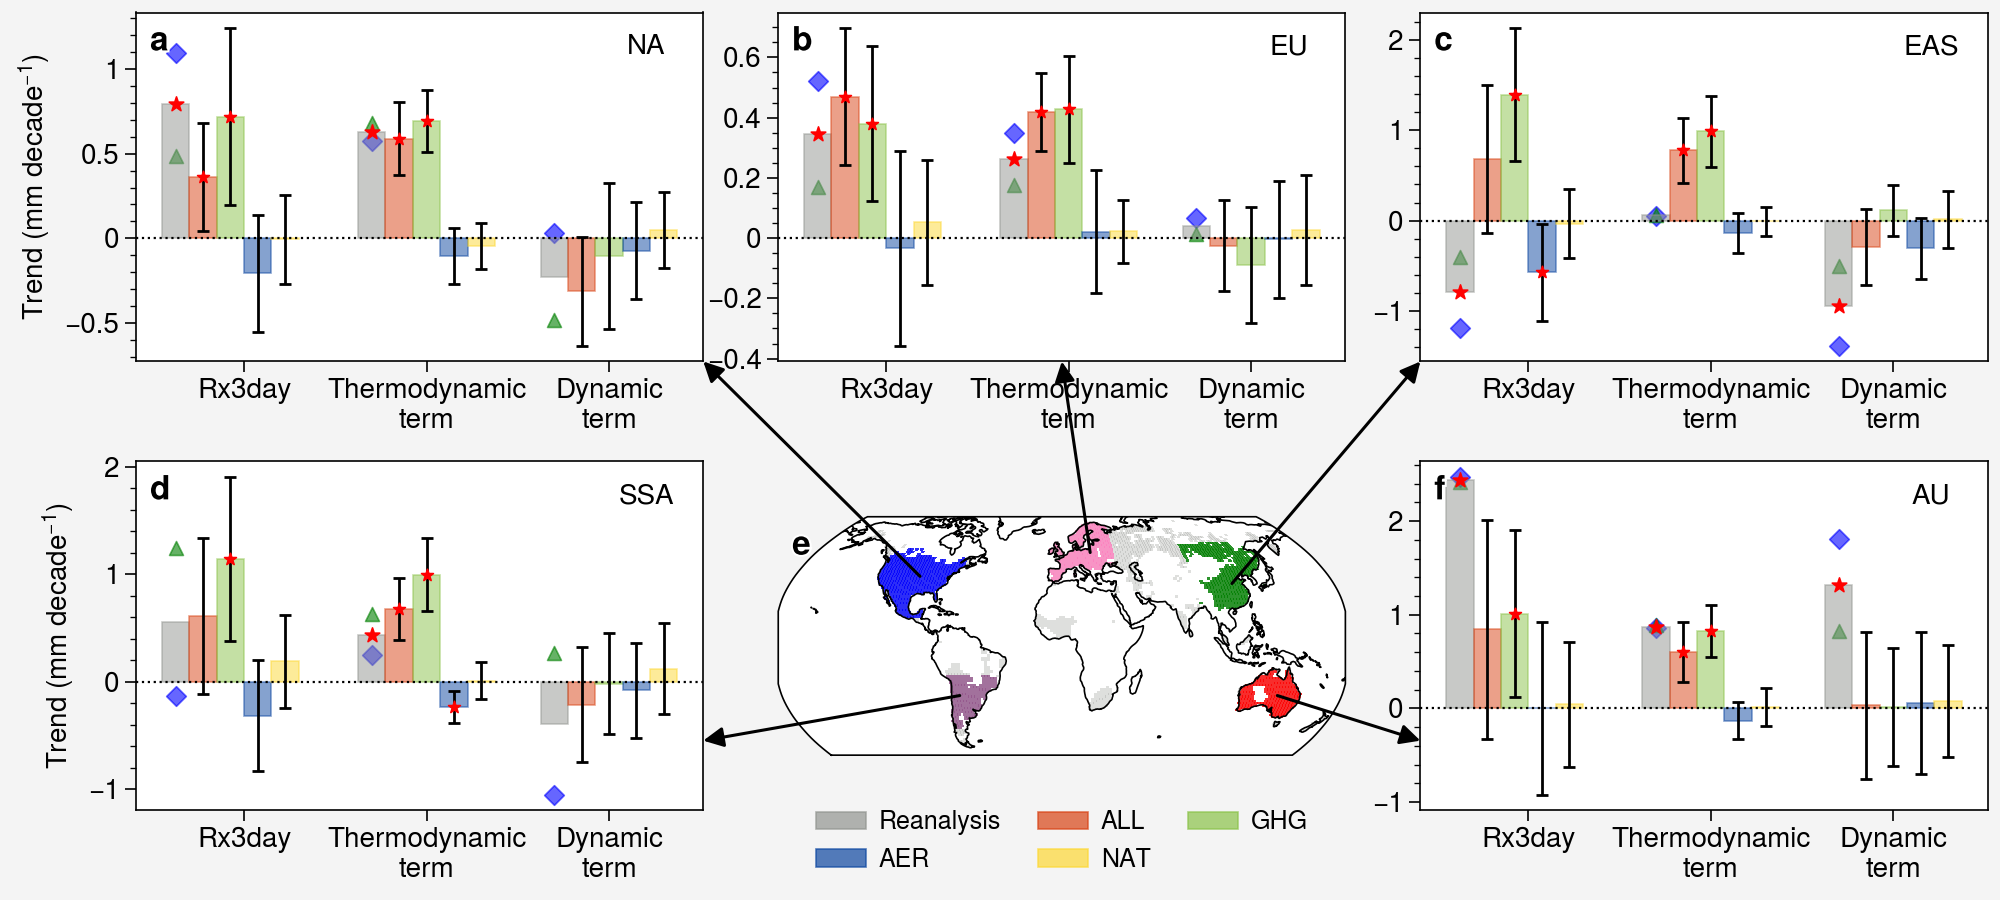

In [3]:
fig, ax = pplot.subplots(ncols=3,nrows=2,wratios=(1,1,1),share=False,wspace=(3,3),hspace=4,
                        proj={5:'robin'},width=10,height=4.5)

ax.format(grid=False)

lons1d = mask_global.lon
lats1d = mask_global.lat

ax[4].pcolormesh(lons1d,lats1d,mask_global,label=False,alpha=0.3,color='gray')
ax[4].pcolormesh(lons1d,lats1d,mask_EAS,label=False,alpha=0.8,color='green')
ax[4].pcolormesh(lons1d,lats1d,mask_EU,label=False,alpha=0.8, color='pink')
ax[4].pcolormesh(lons1d,lats1d,mask_NA,label=False,alpha=0.8, color='blue')
ax[4].pcolormesh(lons1d,lats1d,mask_SSA,label=False,alpha=0.8, color='purple')
ax[4].pcolormesh(lons1d,lats1d,mask_AU,label=False,alpha=0.8, color='red')
ax[4].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=120, latlines=30)

sub_regions = ['NA','EU','EAS','SSA','Global','AU']
masks = [mask_NA,mask_EU,mask_EAS,mask_SSA,mask_global,mask_AU]
x_pos = {'prec':1,'scaling_thermo':2,'scaling_dynamic':3}
width = 1.5
labels = ['Rx3day','Thermodynamic\nterm','Dynamic\nterm']

error_kw=dict(lw=1, capsize=2, capthick=1)

for i in [0,1,2,3,5]:
    mask = sub_regions[i]
    ax_i = ax[i]

    for n in ['prec','scaling_thermo','scaling_dynamic']:
        if n == 'prec':
            bar_data_color = {'reanalysis':'gray','hadex3':'black','historical':'#D84315','hist-GHG':'#8BC34A','hist-aer':'#0D47A1','hist-nat':'#FDD835'}
            for f in ['reanalysis','historical','hist-GHG','hist-aer','hist-nat']:
                color = bar_data_color[f]
                if f == 'reanalysis':
                    era5_series, era5_trend, _, _ = get_reanalysis_weighted_for_mask(name=n,reanalysis='era5',mask=mask)
                    jra55_series, jra55_trend, _, _ = get_reanalysis_weighted_for_mask(name=n,reanalysis='jra55',mask=mask)
                    reanalysis_trend = (era5_trend + jra55_trend) / 2
                    if reanalysis_trend > 0:
                        reanalysis_trend_sig = bs_trend_sig((era5_series + jra55_series).iloc[:,0] / 2) & (era5_trend > 0) & (jra55_trend > 0)
                    else:
                        reanalysis_trend_sig = bs_trend_sig((era5_series + jra55_series).iloc[:,0] / 2) & (era5_trend < 0) & (jra55_trend < 0)

                    reanalysis_x = x_pos[n] - width/10*2 - width/20
                    ax_i.bar(reanalysis_x, reanalysis_trend,align='center',alpha=0.5,width=width*0.2,color=color,edgecolor=color,capsize=10,error_kw=error_kw)
                    if reanalysis_trend_sig == True:
                        ax_i.scatter(reanalysis_x,reanalysis_trend,marker='*',color='red',s=30,zorder=10)
                    ax_i.scatter(reanalysis_x, era5_trend, marker="D",color='blue',alpha=0.6,s=25)
                    ax_i.scatter(reanalysis_x, jra55_trend, marker="^",color='green',alpha=0.6,s=25)
                    mme_x = x_pos[n] - width/10*2 - width/20

                else:
                    mme_ano, mme_trend, mme_trend_sig, data_trend_std = get_ens_weighted_for_mask(name=n,forcing=f,mask=mask)
                    error_f = [data_trend_std]

                    mme_x = mme_x + width/10*1
                    ax_i.bar(mme_x, mme_trend, yerr=error_f, align='center', alpha=0.5, width=width*0.2,color=color,edgecolor=color,capsize=10,error_kw=error_kw)
                    if mme_trend_sig == True:
                        ax_i.scatter(mme_x,mme_trend,marker='*',color='red',s=20,zorder=10)
        else:
            for f in ['reanalysis','historical','hist-GHG','hist-aer','hist-nat']:
                bar_data_color = {'reanalysis':'gray','historical':'#D84315','hist-GHG':'#8BC34A','hist-aer':'#0D47A1','hist-nat':'#FDD835'}
                color = bar_data_color[f]
                if f == 'reanalysis':
                    era5_series, era5_trend, _, _ = get_reanalysis_weighted_for_mask(name=n,reanalysis='era5',mask=mask)
                    jra55_series, jra55_trend, _, _ = get_reanalysis_weighted_for_mask(name=n,reanalysis='jra55',mask=mask)
                    reanalysis_trend = (era5_trend + jra55_trend) / 2
                    if reanalysis_trend > 0:
                        reanalysis_trend_sig = bs_trend_sig((era5_series + jra55_series).iloc[:,0] / 2) & (era5_trend > 0) & (jra55_trend > 0)
                    else:
                        reanalysis_trend_sig = bs_trend_sig((era5_series + jra55_series).iloc[:,0] / 2) & (era5_trend < 0) & (jra55_trend < 0)

                    reanalysis_x = x_pos[n] - width/10*2
                    ax_i.bar(reanalysis_x, reanalysis_trend,align='center',alpha=0.5,width=width*0.2,color=color,edgecolor=color,capsize=10,error_kw=error_kw)
                    if reanalysis_trend_sig == True:
                        ax_i.scatter(reanalysis_x,reanalysis_trend,marker='*',color='red',s=30,zorder=10)
                    ax_i.scatter(reanalysis_x, era5_trend, marker="D",color='blue',alpha=0.6,s=25)
                    ax_i.scatter(reanalysis_x, jra55_trend, marker="^",color='green',alpha=0.6,s=25)
                else:
                    mme_ano, mme_trend, mme_trend_sig, data_trend_std = get_ens_weighted_for_mask(name=n,forcing=f,mask=mask)
                    error_f = [data_trend_std]
                    
                    reanalysis_x = reanalysis_x + width/10*1
                    ax_i.bar(reanalysis_x, mme_trend, yerr=error_f, align='center', alpha=0.5, width=width*0.2,color=color,edgecolor=color,capsize=10,error_kw=error_kw)
                    if mme_trend_sig == True:
                        ax_i.scatter(reanalysis_x,mme_trend,marker='*',color='red',s=20,zorder=10)

    ax_i.set_xticks([1,2,3])
    ax_i.set_xticklabels(labels,fontsize=9)
    ax_i.set_ylabel('Trend (mm ${decade^{-1}}$)',fontsize=10)
    ax_i.tick_params(which='major', labelsize=10)
    ax_i.axhline(y=0,ls=":",lw=0.8,c="black")
    ax_i.text(0.9,0.9,mask,horizontalalignment='center',verticalalignment='center',transform = ax_i.transAxes,size=10)
    if i==0 or i==3:
        ax_i.yaxis.set_ticks_position('left')
        ax_i.yaxis.set_label_position('left')
    elif i==2 or i==5:
        ax_i.yaxis.set_ticks_position('left')
        ax_i.set(ylabel=None)
    else:
        ax_i.yaxis.set_ticks_position('left')
        ax_i.set(ylabel=None)
    ax_i.xaxis.set_tick_params(which='minor',bottom=False)

ax.format(abc=True,abcsize=12,abcloc='ul')

xy5_NA = [ax[4].get_xlim()[0] + (ax[4].get_xlim()[1] - ax[4].get_xlim()[0]) * 0.25, ax[4].get_ylim()[0] + (ax[4].get_ylim()[1] - ax[4].get_ylim()[0]) * 0.75]
xy5_SSA = [ax[4].get_xlim()[0] + (ax[4].get_xlim()[1] - ax[4].get_xlim()[0]) * 0.32, ax[4].get_ylim()[0] + (ax[4].get_ylim()[1] - ax[4].get_ylim()[0]) * 0.25]
xy5_EU = [ax[4].get_xlim()[0] + (ax[4].get_xlim()[1] - ax[4].get_xlim()[0]) * 0.55, ax[4].get_ylim()[0] + (ax[4].get_ylim()[1] - ax[4].get_ylim()[0]) * 0.85]
xy5_EAS = [ax[4].get_xlim()[0] + (ax[4].get_xlim()[1] - ax[4].get_xlim()[0]) * 0.8, ax[4].get_ylim()[0] + (ax[4].get_ylim()[1] - ax[4].get_ylim()[0]) * 0.72]
xy5_AU = [ax[4].get_xlim()[0] + (ax[4].get_xlim()[1] - ax[4].get_xlim()[0]) * 0.88, ax[4].get_ylim()[0] + (ax[4].get_ylim()[1] - ax[4].get_ylim()[0]) * 0.25]


from matplotlib import patches

# Add line from one subplot to the other
xy1_NA = [ax[0].get_xlim()[1],ax[0].get_ylim()[0]]
xy2_EU = [ax[1].get_xlim()[0] + (ax[1].get_xlim()[1] - ax[1].get_xlim()[0]) / 2,ax[1].get_ylim()[0]]
xy3_EAS = [ax[2].get_xlim()[0],ax[2].get_ylim()[0]]
xy4_SSA = [ax[3].get_xlim()[1],ax[3].get_ylim()[0] + (ax[3].get_ylim()[1] - ax[3].get_ylim()[0]) / 5]
xy6_AU = [ax[5].get_xlim()[0],ax[5].get_ylim()[0] + (ax[5].get_ylim()[1] - ax[5].get_ylim()[0]) / 5]

# ConnectionPatch handles the transform internally so no need to get fig.transFigure
arrow1 = patches.ConnectionPatch(xy5_NA,xy1_NA,
    coordsA=ax[4].transData,
    coordsB=ax[0].transData,
    color="black",arrowstyle="-|>", mutation_scale=15, linewidth=1.1,
)
arrow2 = patches.ConnectionPatch(xy5_EU,xy2_EU,
    coordsA=ax[4].transData,
    coordsB=ax[1].transData,
    color="black",arrowstyle="-|>", mutation_scale=15, linewidth=1.1,
)
arrow3 = patches.ConnectionPatch(xy5_EAS,xy3_EAS,
    coordsA=ax[4].transData,
    coordsB=ax[2].transData,
    color="black",arrowstyle="-|>", mutation_scale=15, linewidth=1.1,
)
arrow4 = patches.ConnectionPatch(xy5_SSA,xy4_SSA,
    coordsA=ax[4].transData,
    coordsB=ax[3].transData,
    color="black",arrowstyle="-|>", mutation_scale=15, linewidth=1.1,
)
arrow6 = patches.ConnectionPatch(xy5_AU,xy6_AU,
    coordsA=ax[4].transData,
    coordsB=ax[5].transData,
    color="black",arrowstyle="-|>", mutation_scale=15, linewidth=1.1,
)
fig.patches.append(arrow1)
fig.patches.append(arrow2)
fig.patches.append(arrow3)
fig.patches.append(arrow4)
fig.patches.append(arrow6)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='gray', edgecolor='gray',alpha=0.7,label='Reanalysis'),
                   Patch(facecolor='#D84315', edgecolor='#D84315',alpha=0.7,label='ALL'),
                   Patch(facecolor='#8BC34A', edgecolor='#8BC34A',alpha=0.7,label='GHG'),
                   Patch(facecolor='#0D47A1', edgecolor='#0D47A1',alpha=0.7,label='AER'),
                   Patch(facecolor='#FDD835', edgecolor='#FDD835',alpha=0.7,label='NAT')]
fig.legend(handles=legend_elements,col=2,ncol=3,fontsize=13,loc='b',frame=False)

fig_dir = '/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_plot_NW/Figures/'
fig.savefig(fig_dir+'FigS17_Rx3day_regional_anomalies_and_trends.pdf')
fig.savefig(fig_dir+'FigS17_Rx3day_regional_anomalies_and_trends.png',dpi=250)
